In [5]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

In [3]:
PREDS_PATH = "/data/yosef3/scratch/ruchir/pgp_finetuning/1_pairwise/test_preds/"
GEUVADIS_COUNTS_PATH = "/data/yosef3/users/ruchir/pgp_finetuning/process_geuvadis_data/tpm/tpm_pca_annot.csv"
BASELINE_PREDS_PATH = (
    "/data/yosef3/users/ruchir/pgp_uq/data/model_perf/all_enformer_df.csv"
)

In [4]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df

In [6]:
def load_finetuned_preds() -> defaultdict[dict]:
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    for (pred, gene, sample) in zip(preds, genes, samples):
        preds_by_gene[gene][sample] = pred
    return preds_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df) -> dict[str, float]:
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
    return corrs


def compare_to_geuvadis_counts(finetuned_preds, geuvadis_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    gene_preds = [finetuned_preds[gene][s] for s in samples]
    gene_counts = geuvadis_df.loc[gene, samples].values
    ax.scatter(gene_counts, gene_preds)
    ax.set(
        xlabel="Geuvadis counts",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(gene_preds, gene_counts)[0]:.3f}",
    )


def compare_to_baseline_counts(finetuned_preds, baseline_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    baseline_preds = baseline_df[gene][samples].values
    finetuned_preds = [finetuned_preds[gene][s] for s in samples]
    ax.scatter(baseline_preds, finetuned_preds)
    ax.set(
        xlabel="baseline predictions",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(baseline_preds, finetuned_preds)[0]:.3f}",
    )

In [7]:
def load_baseline_preds() -> pd.DataFrame:
    baseline_df = pd.read_csv(BASELINE_PREDS_PATH, index_col=0)
    return baseline_df


def get_baseline_corrs(baseline_df, geuvadis_df, finetuned_preds) -> dict[str, float]:
    corrs = {}
    for g in finetuned_preds:
        assert g in baseline_df.columns
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = baseline_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
    return corrs

In [8]:
geuvadis_df = load_geuvadis_data()

In [9]:
finetuned_preds = load_finetuned_preds()
finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)

In [10]:
baseline_df = load_baseline_preds()
baseline_corrs = get_baseline_corrs(baseline_df, geuvadis_df, finetuned_preds)

In [18]:
def compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, abs_baseline: bool = False
):
    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    baseline_corrs_l = [baseline_corrs[g] for g in genes]
    is_YRI_test_gene = [len(finetuned_preds[g]) < 421 for g in genes]

    df = pd.DataFrame(
        {
            "gene": genes,
            "finetuned Spearman": finetuned_corrs_l,
            "baseline Spearman": np.abs(baseline_corrs_l)
            if abs_baseline
            else baseline_corrs_l,
            "trained on non-YRI samples": is_YRI_test_gene,
        }
    )

    ax = sns.scatterplot(
        data=df,
        x="baseline Spearman",
        y="finetuned Spearman",
        hue="trained on non-YRI samples",
    )
    ax.set_xlabel("|baseline Spearman|" if abs_baseline else "baseline Spearman")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set(aspect="equal", xlim=lims, ylim=lims)

    ax.axhline(
        df[df["trained on non-YRI samples"]]["finetuned Spearman"].mean(),
        color="orange",
        ls="--",
    )
    ax.axvline(
        df[df["trained on non-YRI samples"]]["baseline Spearman"].mean(),
        color="orange",
        ls="--",
    )

    ax.axhline(
        df[~df["trained on non-YRI samples"]]["finetuned Spearman"].mean(),
        color="blue",
        ls="--",
    )
    ax.axvline(
        df[~df["trained on non-YRI samples"]]["baseline Spearman"].mean(),
        color="blue",
        ls="--",
    )

    plt.show()
    return df

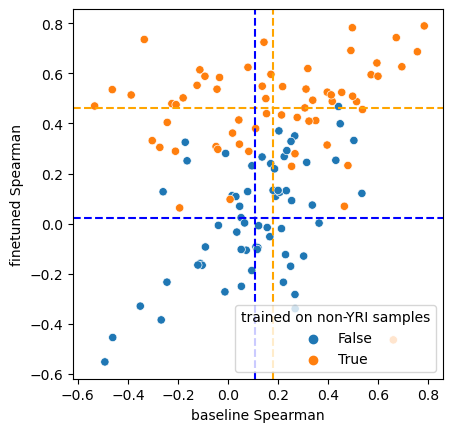

In [19]:
metrics_df = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds
)

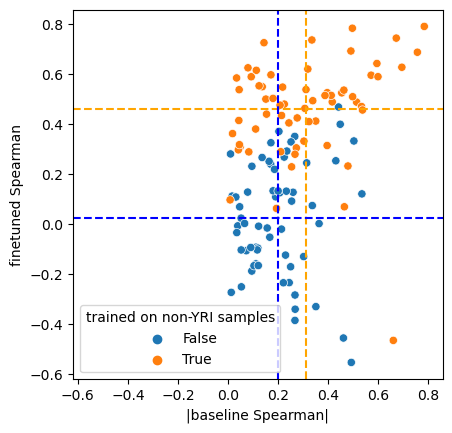

In [21]:
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, abs_baseline=True
)